In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## Load Data

In [3]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
from transformers import *

In [4]:
# train_Xy = pd.read_csv('exploratory_data_analysis/data_elasticsearch/train_Xy.csv')
# val_Xy = pd.read_csv('exploratory_data_analysis/data_elasticsearch//val_Xy.csv')
# test_Xy = pd.read_csv('exploratory_data_analysis/data_elasticsearch//test_Xy.csv')

In [5]:
train_Xy = pd.read_csv('exploratory_data_analysis/data_teammates/train_Xy.csv')
val_Xy = pd.read_csv('exploratory_data_analysis/data_teammates//val_Xy.csv')
test_Xy = pd.read_csv('exploratory_data_analysis/data_teammates//test_Xy.csv')

In [6]:
train_Xy.head()

augmented_diff_hunk  \
0  --- TimeHelper.java\n+++ TimeHelper.java\n@@ -...   
1  --- InstructorFeedbackAbstractAction.java\n+++...   
2  --- AdminActivityLogPageData.java\n+++ AdminAc...   
3  --- FeedbackResendLinksAction.java\n+++ Feedba...   
4  --- FeedbackResponseAttributesTest.java\n+++ F...   

                                                body  
0  See if it can be defined in one place and used...  
1  Also capitalise the first letter (applies to a...  
2   Not from your PR but is this constant a typo? \n  
3  Should use `FieldValidator` instead of handlin...  
4  Following the discussion from https://github.c...

In [7]:
val_Xy.head()

augmented_diff_hunk  \
0  --- InstructorFeedbackEditPageData.java\n+++ I...   
1  --- FeedbackNumericalScaleQuestionDetails.java...   
2  --- InstructorCourseDetailsPageData.java\n+++ ...   
3  --- FeedbackResponseCommentAttributes.java\n++...   
4  --- InstructorFeedbackEditCopyAction.java\n+++...   

                                                body  
0  I wonder if it will be better if we just retur...  
1  No need to check for null if hiddenRecipients ...  
2  Split this method into multiple methods.\nIt's...  
3  A quick comment:\r\nThis field should remain a...  
4           this line break is unnecessary, right?\n

In [8]:
test_Xy.head()

augmented_diff_hunk  \
0  --- EntityAttributes.java\n+++ EntityAttribute...   
1  --- FeedbackResendLinksAction.java\n+++ Feedba...   
2  --- InstructorFeedbackResultsQuestionTable.jav...   
3  --- AdminActivityLogPageData.java\n+++ AdminAc...   
4  --- CreateFeedbackResponseActionTest.java\n+++...   

                                                body  
0  ```java\r\n* @param error a potentially empty ...  
1       This feature does not require authentication  
2  Does the method and attribute require the "Que...  
3  Should be `* Returns true ...` ?\r\nOverview s...  
4  `nonEmptyPreviewParam` should be a valid stude...

In [9]:
def consolidate_data(df):
    return df.to_dict(orient='records')

In [10]:
train_data = consolidate_data(train_Xy)
val_data = consolidate_data(val_Xy)
test_data = consolidate_data(test_Xy)

In [11]:
len(train_data)

7629

In [12]:
len(val_data)

1347

In [13]:
len(test_data)

1225

## Data Preprocessing

In [14]:
from transformers import *

In [15]:
code_pretrained_weights = 'huggingface/CodeBERTa-small-v1'
code_tokenizer = AutoTokenizer.from_pretrained(code_pretrained_weights)

In [16]:
data_scores = pd.read_csv('code_to_score/saved_data/data_scores.csv', lineterminator='\n')
data_scores

Unnamed: 0   vader  textblob  senticr  \
0               0  0.0000  0.000000      0.0   
1               1  0.0000  0.250000      0.0   
2               2  0.0000  0.000000      0.0   
3               3  0.0000  0.100000      0.0   
4               4  0.6358 -0.103009     -1.0   
...           ...     ...       ...      ...   
10196       10196  0.0000  0.000000      0.0   
10197       10197  0.0000 -0.062500      0.0   
10198       10198  0.0772  0.250000      0.0   
10199       10199  0.0000  0.000000      0.0   
10200       10200  0.2500  0.000000      0.0   

                                                    body  flair  
0      See if it can be defined in one place and used...    0.0  
1      Also capitalise the first letter (applies to a...    0.0  
2         Not from your PR but is this constant a typo?    -1.0  
3      Should use FieldValidator instead of handling ...   -1.0  
4      Following the discussion from https://github.c...   -1.0  
...                                                  ...    ...  
10196  Use this to reduce nesting? javaif (JDOHelper....    0.0  
10197  The repetitions are still there. Take a look t...   -1.0  
10198  does the number of logs have to be more than t...    0.0  
10199                                   double semicolon    0.0  
10200  I see I see, it's alright, let's just do it in...    0.0  

[10201 rows x 6 columns]

In [17]:
diff_max_length = 300

score_method = 'flair'
score_method = 'senticr'
score_method = 'vader'
score_method = 'textblob'
is_classification = score_method == 'flair' or score_method == 'senticr'

In [18]:
def data_preprocess(data, idx, method):
    i = idx
    for record in data:
        if is_classification:
            record['score'] = int(data_scores[method].values[i] + 1) # classification 
        else:
            record['score'] = data_scores[method].values[i] # regression
            
        dict_data = code_tokenizer.encode_plus(record['augmented_diff_hunk'], max_length=diff_max_length, pad_to_max_length=True)
        record['diff_hunk_encoded'] = np.array(dict_data['input_ids'])
        record['diff_hunk_mask'] = np.array(dict_data['attention_mask'])
        i += 1
    print(i)
data_preprocess(train_data, 0, score_method)
data_preprocess(val_data, len(train_data), score_method)
data_preprocess(test_data, len(train_data) + len(val_data), score_method)

7629
8976
10201


## Build Batch

In [19]:
def build_batch(dataset, batch_size):
    indices = list(np.random.randint(0, len(dataset), size=min(batch_size, len(dataset))))
    
    batch = [dataset[i] for i in indices]
    
    X_encoded = np.array([element['diff_hunk_encoded'] for element in batch])
    X_mask = np.array([element['diff_hunk_mask'] for element in batch])
    
    y_target = np.array([element['score'] for element in batch])

    return X_encoded, X_mask, y_target

In [20]:
X_encoded, X_mask, y_target = build_batch(train_data, 10)

In [21]:
print(X_encoded.shape)
print(X_mask.shape)
print(y_target.shape)

(10, 300)
(10, 300)
(10,)


## Model

In [22]:
import torch
import torch.nn as nn

In [23]:
from code_to_score.models.code_to_score_transformer import CodeToScoreModelTransformer

## Visualization

In [24]:
from util.training_process_recorder import TrainingProcess

## Trainning

In [25]:
from sklearn.metrics import accuracy_score

In [26]:
code_to_score_model = CodeToScoreModelTransformer(
    is_classification=is_classification, class_weight=[2, 1],
    code_pretrained_weights=code_pretrained_weights, 
    should_tune_encoder=False,
    code_max_length=diff_max_length)
code_to_score_model = code_to_score_model.to(code_to_score_model.device)

In [ ]:
code_to_score_model = CodeToScoreModelTransformer(
    is_classification=is_classification, class_weight=[2, 1],
    code_pretrained_weights=code_pretrained_weights, 
    should_tune_encoder=True,
    code_max_length=diff_max_length)
code_to_score_model = code_to_score_model.to(code_to_score_model.device)

In [27]:
tp = TrainingProcess()
tp_acc = TrainingProcess()

In [28]:
if torch.cuda.is_available():
    code_to_score_model.load_state_dict(torch.load('code_to_score/saved_data/{}_code_to_score_transformer_code_bert.save'.format(score_method)))
else:
    code_to_score_model.load_state_dict(torch.load('code_to_score/saved_data/{}_code_to_score_transformer_code_bert.save'.format(score_method), 
                                                    map_location=torch.device('cpu')))

code_to_score_model.eval();
tp.load("code_to_score/saved_data/{}_code_to_score_transformer_code_bert_tp.save".format(score_method))
if is_classification:
    tp_acc.load("code_to_score/saved_data/{}_code_to_score_transformer_code_bert_tp_acc.save".format(score_method))

In [ ]:
if torch.cuda.is_available():
    code_to_score_model.load_state_dict(torch.load('code_to_score/saved_data/{}_code_to_score_transformer_code_bert_tune.save'.format(score_method)))
else:
    code_to_score_model.load_state_dict(torch.load('code_to_score/saved_data/{}_code_to_score_transformer_code_bert_tune.save'.format(score_method), 
                                                    map_location=torch.device('cpu')))

code_to_score_model.eval();
tp.load("code_to_score/saved_data/{}_code_to_score_transformer_code_bert_tune_tp.save".format(score_method))
if is_classification:
    tp_acc.load("code_to_score/saved_data/{}_code_to_score_transformer_code_bert_tune_tp_acc.save".format(score_method))

In [ ]:
optimizer = torch.optim.Adam([
                {'params': code_to_score_model.affine_1.parameters()},
                {'params': code_to_score_model.affine_1_activation.parameters()},
                {'params': code_to_score_model.affine_2.parameters()},
                {'params': code_to_score_model.code_model.parameters(), 'lr': 0.00012}
            ], lr=0.0002, weight_decay=0.02)
my_lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.995)

num_epochs = 15
batch_size = 64
log_step = 30

for epoch in range(num_epochs):
    num_train = len(train_data)
    iterations_per_epoch = max(num_train // batch_size, 1)
    
    for i in range(iterations_per_epoch):
        minibatch = build_batch(train_data, batch_size)
        X_encoded, X_mask, y_target = minibatch
        code_to_score_model.train()
        code_to_score_model.zero_grad()
        loss = code_to_score_model(X_encoded, X_mask, y_target)
        loss.backward()
        optimizer.step()
        
        tp.record_train(loss.item())
        tp.step()
        
        # Print log info
        if i % log_step == 0:
            if is_classification:
                score_out = code_to_score_model(X_encoded, X_mask).argmax(dim=1)
                train_acc = accuracy_score(score_out.detach().cpu(), y_target)
                tp_acc.record_train(train_acc)
                print('Epoch [{}/{}], Step [{}/{}], Acc: {:.4f}'.format(epoch + 1, num_epochs, i, iterations_per_epoch, train_acc))
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch + 1, num_epochs, i, iterations_per_epoch, loss.item()))
        
        if is_classification:
            tp_acc.step()

    val_minibatch = build_batch(val_data, batch_size)
    val_X_encoded, val_X_mask, val_y_target = val_minibatch
    code_to_score_model.eval()
    code_to_score_model.zero_grad()
    val_loss = code_to_score_model(val_X_encoded, val_X_mask, val_y_target)

    tp.record_val(val_loss.item())
    
    if is_classification:
        score_out = code_to_score_model(val_X_encoded, val_X_mask).argmax(dim=1)
        val_acc = accuracy_score(score_out.detach().cpu(), val_y_target)
        tp_acc.record_val(val_acc)
        print('Epoch [{}/{}], Validation Accuracy: {:.4f} '.format(epoch + 1, num_epochs, val_acc))

    print('Epoch [{}/{}], Validation Loss: {:.4f}'.format(epoch + 1, num_epochs, val_loss.item()))
    
    tp.record_epoch()
    if is_classification:
        tp_acc.record_epoch()
    
    my_lr_scheduler.step()

In [ ]:
baseline_acc_list = []

for i in range(len(test_data) // 64):
    test_minibatch = build_batch(test_data, 64)
    test_X_encoded, test_X_mask, test_y_target = test_minibatch
    code_to_score_model.eval()
    code_to_score_model.zero_grad()
    test_loss = code_to_score_model(test_X_encoded, test_X_mask, test_y_target)
    
    tp.record_test(test_loss.item())
    
    if is_classification:
        score_out = code_to_score_model(test_X_encoded, test_X_mask).argmax(dim=1)
        test_acc = accuracy_score(score_out.detach().cpu(), test_y_target)
        tp_acc.record_test(test_acc)
        print('[Round {}] Test Accuracy: {:.4f}'.format(i + 1, test_acc))
        baseline_score = np.zeros(len(test_y_target))
        baseline_acc = accuracy_score(baseline_score, test_y_target)
        baseline_acc_list.append(baseline_acc)
        print('[Round {}] Baseline Test Accuracy: {:.4f}'.format(i + 1, baseline_acc))

    print('[Round {}] Test Loss: {:.4f}'.format(i + 1, test_loss.item()))

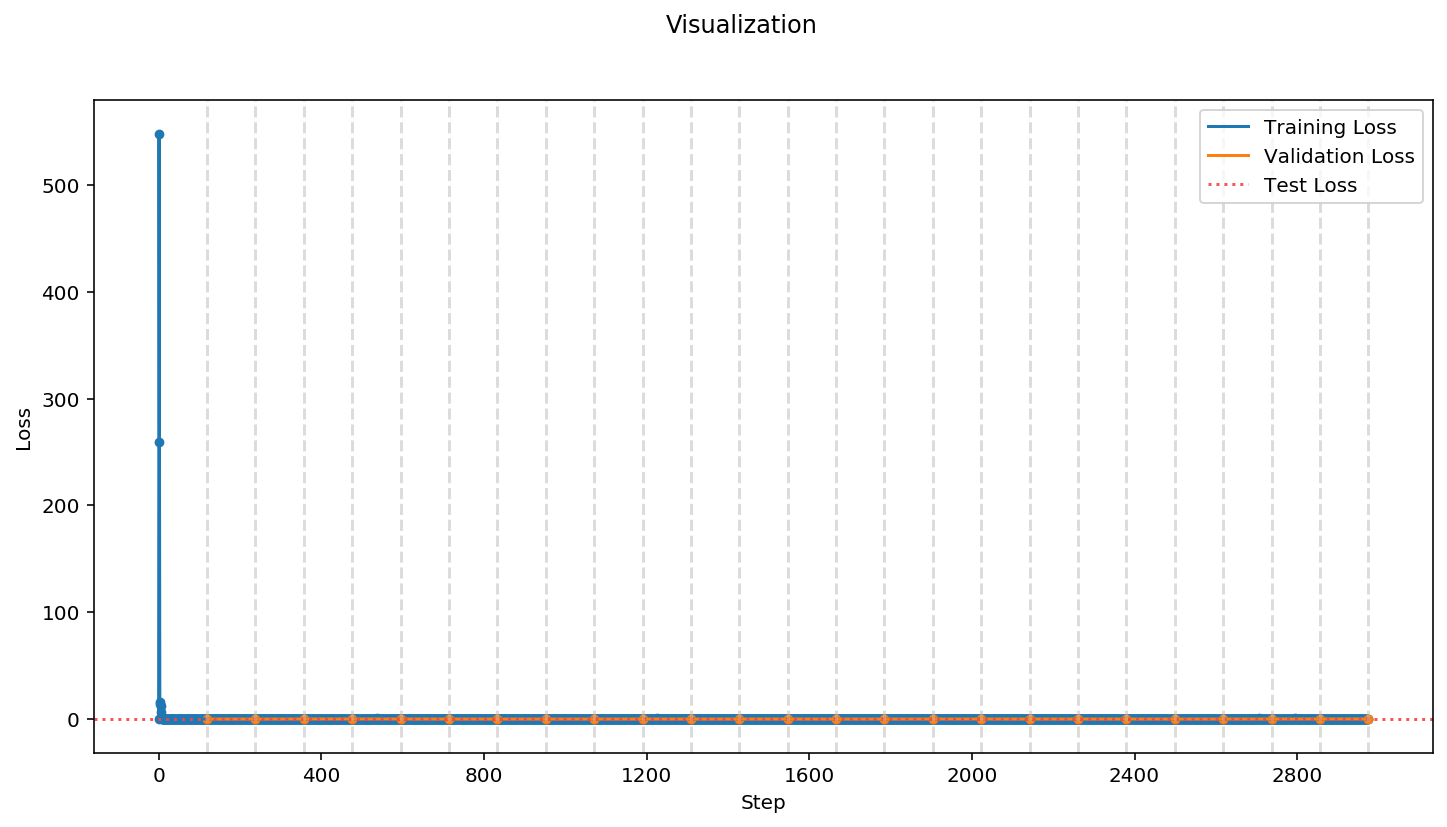

In [29]:
tp.visualize()

In [30]:
if is_classification:
    tp_acc.visualize(legend=['Training Acc', 'Validation Acc', 'Test Acc'])
    print(np.mean(baseline_acc_list))

In [ ]:
torch.save(code_to_score_model.state_dict(), 'code_to_score/saved_data/{}_code_to_score_transformer_code_bert.save'.format(score_method))
tp.save('code_to_score/saved_data/{}_code_to_score_transformer_code_bert_tp.save'.format(score_method))
if is_classification:
    tp_acc.save('code_to_score/saved_data/{}_code_to_score_transformer_code_bert_tp_acc.save'.format(score_method))

In [ ]:
torch.save(code_to_score_model.state_dict(), 'code_to_score/saved_data/{}_code_to_score_transformer_code_bert_tune.save'.format(score_method))
tp.save('code_to_score/saved_data/{}_code_to_score_transformer_code_bert_tune_tp.save'.format(score_method))
if is_classification:
    tp_acc.save('code_to_score/saved_data/{}_code_to_score_transformer_code_bert_tune_tp_acc.save'.format(score_method))

## Testing

In [31]:
test_minibatch = build_batch(test_data, 64)
test_X_encoded, test_X_mask, test_y_target = test_minibatch

scores = code_to_score_model(test_X_encoded, test_X_mask).detach().cpu().numpy()

plt.figure(figsize=(12,4))
plt.subplot(121)

plt.hist(scores)
plt.legend(['Predicted Score',])
plt.xlabel('Score')

plt.subplot(122)
plt.hist(test_y_target)
plt.legend(['Ground Truth',])

plt.suptitle('Predicted Score and Ground Truth Distributions\n (Test Data with Batch = 64)')
plt.xlabel('Score')

Text(0.5, 0, 'Score')

Text(0.5, 0, 'Score')

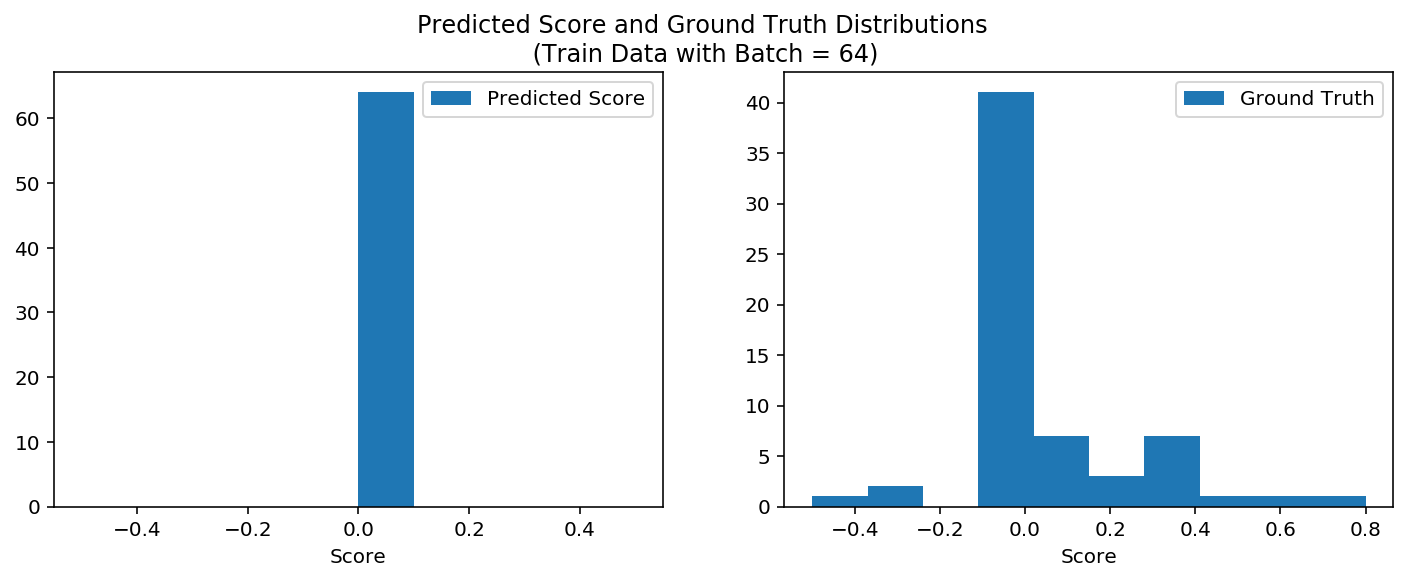

In [32]:
train_minibatch = build_batch(train_data, 64)
train_X_encoded, train_X_mask, train_y_target = train_minibatch

scores = code_to_score_model(train_X_encoded, train_X_mask).detach().cpu().numpy()

plt.figure(figsize=(12,4))
plt.subplot(121)

plt.hist(scores)
plt.legend(['Predicted Score',])
plt.xlabel('Score')

plt.subplot(122)
plt.hist(train_y_target)
plt.legend(['Ground Truth',])

plt.suptitle('Predicted Score and Ground Truth Distributions\n (Train Data with Batch = 64)')
plt.xlabel('Score')

In [33]:
from sklearn import metrics

def calculate_roc(data):
    minibatch = build_batch(data, 64)
    X_encoded, X_mask, y_target = minibatch
    scores = code_to_score_model(X_encoded, X_mask).detach().cpu().numpy()
    # pos label
    scores = scores[:, 1]
    fpr, tpr, thresholds = metrics.roc_curve(y_target, scores, pos_label=1)
    auc = metrics.auc(fpr, tpr)
    return fpr, tpr, auc
    
if is_classification:
    train_fpr, train_tpr, train_auc = calculate_roc(train_data)
    test_fpr, test_tpr, test_auc = calculate_roc(test_data)
    val_fpr, val_tpr, val_auc = calculate_roc(val_data)

    plt.figure(figsize=(8,6))
    plt.plot(train_fpr, train_tpr)
    plt.plot(val_fpr, val_tpr)
    plt.plot(test_fpr, test_tpr)
    plt.title('ROC curve (Batch = 400)')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.legend(['Train (AUC = {:.2f})'.format(train_auc), 'Val (AUC = {:.2f})'.format(val_auc), 'Test (AUC = {:.2f})'.format(test_auc)])
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')